<a href="https://colab.research.google.com/github/indiradrr/VariationalAutoencoder/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os


In [80]:

class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
        self.folder_path = folder_path
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_name).convert("L")  # Grayscale
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_dataset_path = '/content/drive/MyDrive/keras_png_slices_data/keras_png_slices_train'
val_dataset_path = '/content/drive/MyDrive/keras_png_slices_data/keras_png_slices_validate'
test_dataset_path = '/content/drive/MyDrive/keras_png_slices_data/keras_png_slices_test'

batch_size = 128

# Create datasets
train_dataset = CustomDataset(folder_path=train_dataset_path, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomDataset(folder_path=val_dataset_path, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = CustomDataset(folder_path=test_dataset_path, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


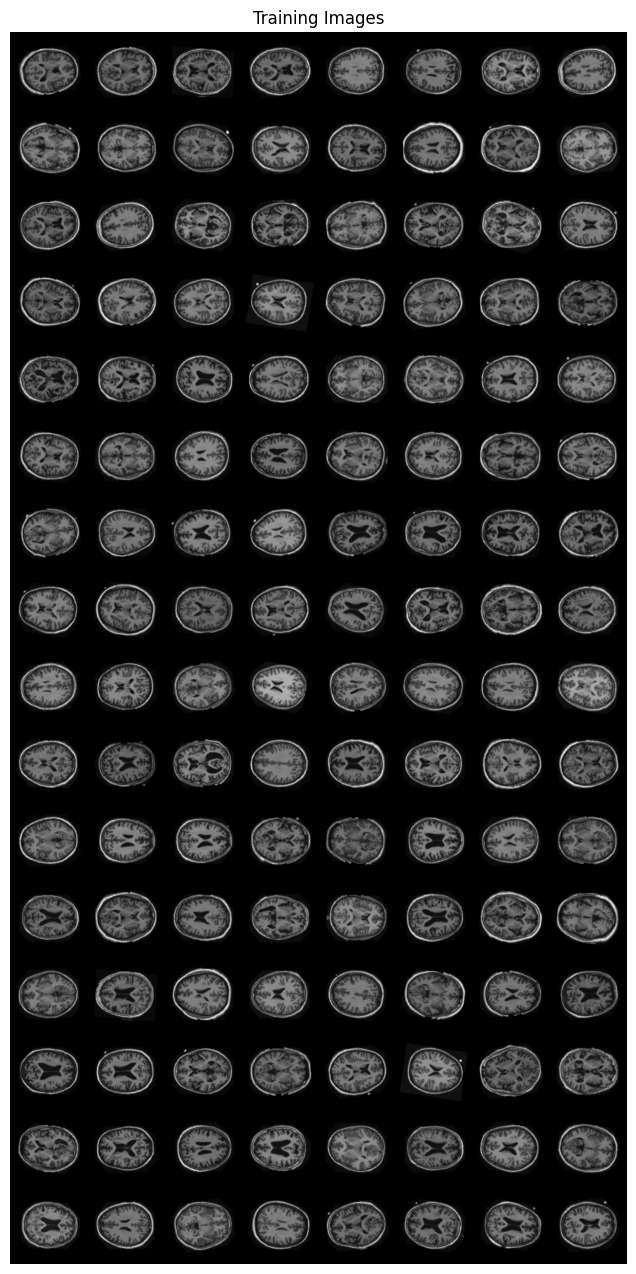

In [68]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Get a batch of training data
dataiter = iter(train_dataloader)
images = next(dataiter)

# Create a grid from the images
grid = vutils.make_grid(images, nrow=8, padding=2, normalize=True)

# Plot the images
plt.figure(figsize=(16, 16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.show()


In [81]:
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, z_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  # B, 32, 64, 64
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # B, 64, 32, 32
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # B, 128, 16, 16
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), # B, 256, 8, 8
            nn.Flatten(),
            nn.Linear(256*8*8, 2*z_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 256*8*8),
            nn.Unflatten(1, (256, 8, 8)),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var


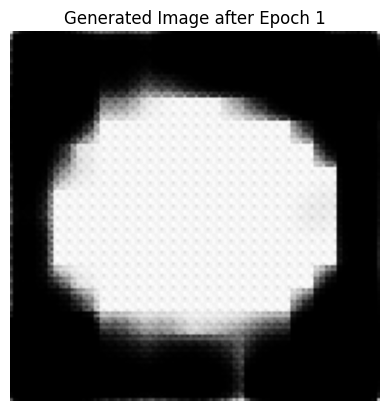

Epoch [1/10], Batch [63] - Loss: 10.8163, Recon: 0.0393, KLD: 10.7770, Time: 32.41s


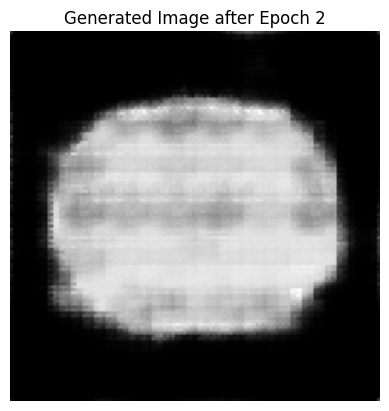

Epoch [2/10], Batch [63] - Loss: 0.0237, Recon: 0.0115, KLD: 0.0122, Time: 61.11s


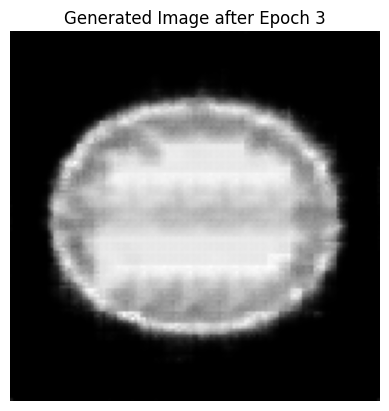

Epoch [3/10], Batch [63] - Loss: 0.0096, Recon: 0.0095, KLD: 0.0001, Time: 89.76s


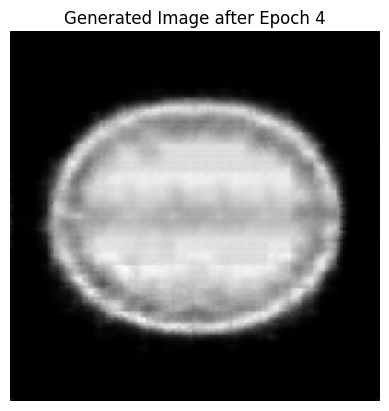

Epoch [4/10], Batch [63] - Loss: 0.0091, Recon: 0.0090, KLD: 0.0000, Time: 118.36s


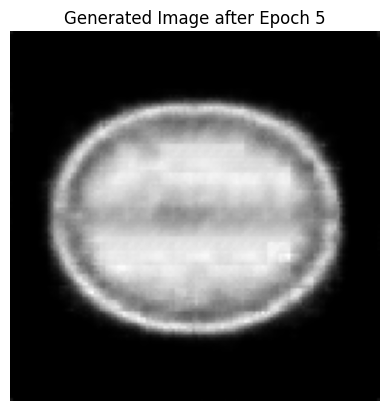

Epoch [5/10], Batch [63] - Loss: 0.0093, Recon: 0.0093, KLD: -0.0000, Time: 147.06s


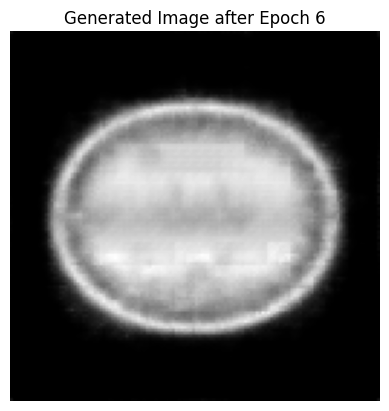

Epoch [6/10], Batch [63] - Loss: 0.0090, Recon: 0.0090, KLD: 0.0000, Time: 175.74s


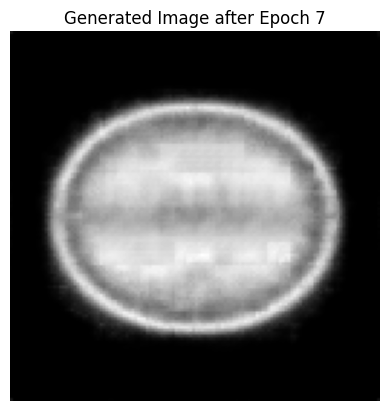

Epoch [7/10], Batch [63] - Loss: 0.0092, Recon: 0.0092, KLD: 0.0000, Time: 204.37s


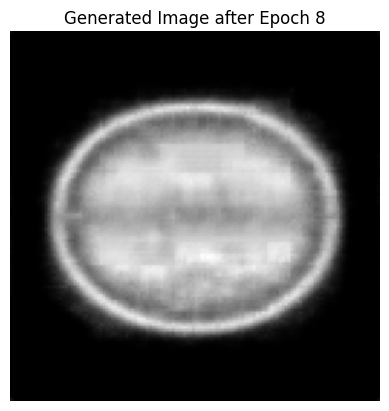

Epoch [8/10], Batch [63] - Loss: 0.0090, Recon: 0.0090, KLD: 0.0000, Time: 233.09s


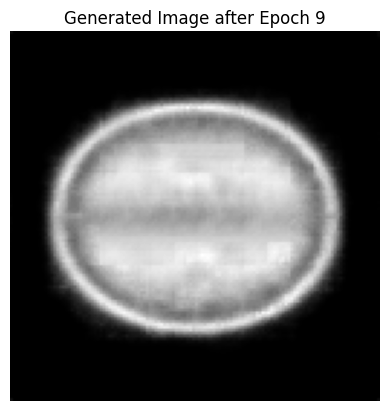

Epoch [9/10], Batch [63] - Loss: 0.0094, Recon: 0.0094, KLD: 0.0000, Time: 262.32s


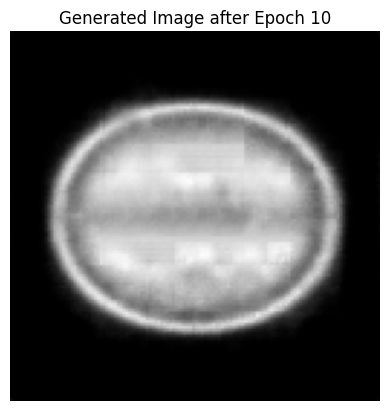

Epoch [10/10], Batch [63] - Loss: 0.0089, Recon: 0.0089, KLD: 0.0000, Time: 291.15s


In [82]:
import time
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE(z_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

epochs = 10
start_time = time.time()

# outer loop for tqdm to show epoch progress
for epoch in range(epochs):
    # inner loop to show batch progress within each epoch
    pbar = tqdm(enumerate(train_dataloader), desc='Batch', leave=False)
    for i, imgs in pbar:
        imgs = imgs.to(device)
        recon, mu, log_var = model(imgs)

        # Reconstruction loss
        recon_loss = nn.functional.mse_loss(recon, imgs)

        # KL divergence
        kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Total loss
        loss = recon_loss + kld

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        elapsed_time = time.time() - start_time
        pbar.set_description(f"Epoch [{epoch + 1}/10], Batch [{i + 1}] - Loss: {loss.item():.4f}, Recon: {recon_loss.item():.4f}, KLD: {kld.item():.4f}, Time: {elapsed_time:.2f}s")

    # Save the model weights after each epoch
    torch.save(model.state_dict(), f"model_epoch_{epoch}.pth")

    # Generate some images using the current model
    z = torch.randn(1, 64).to(device)

    with torch.no_grad():
        generated_image = model.decoder(z)

    # Convert the generated image to a numpy array and plot it
    generated_image_np = generated_image.cpu().squeeze().numpy()
    plt.imshow(generated_image_np, cmap='gray')
    plt.title(f"Generated Image after Epoch {epoch+1}")
    plt.axis('off')
    plt.savefig(f"generated_image_epoch_{epoch}.png")  # Save the image to disk
    plt.show()

    print(f"Epoch [{epoch + 1}/10], Batch [{i + 1}] - Loss: {loss.item():.4f}, Recon: {recon_loss.item():.4f}, KLD: {kld.item():.4f}, Time: {elapsed_time:.2f}s")


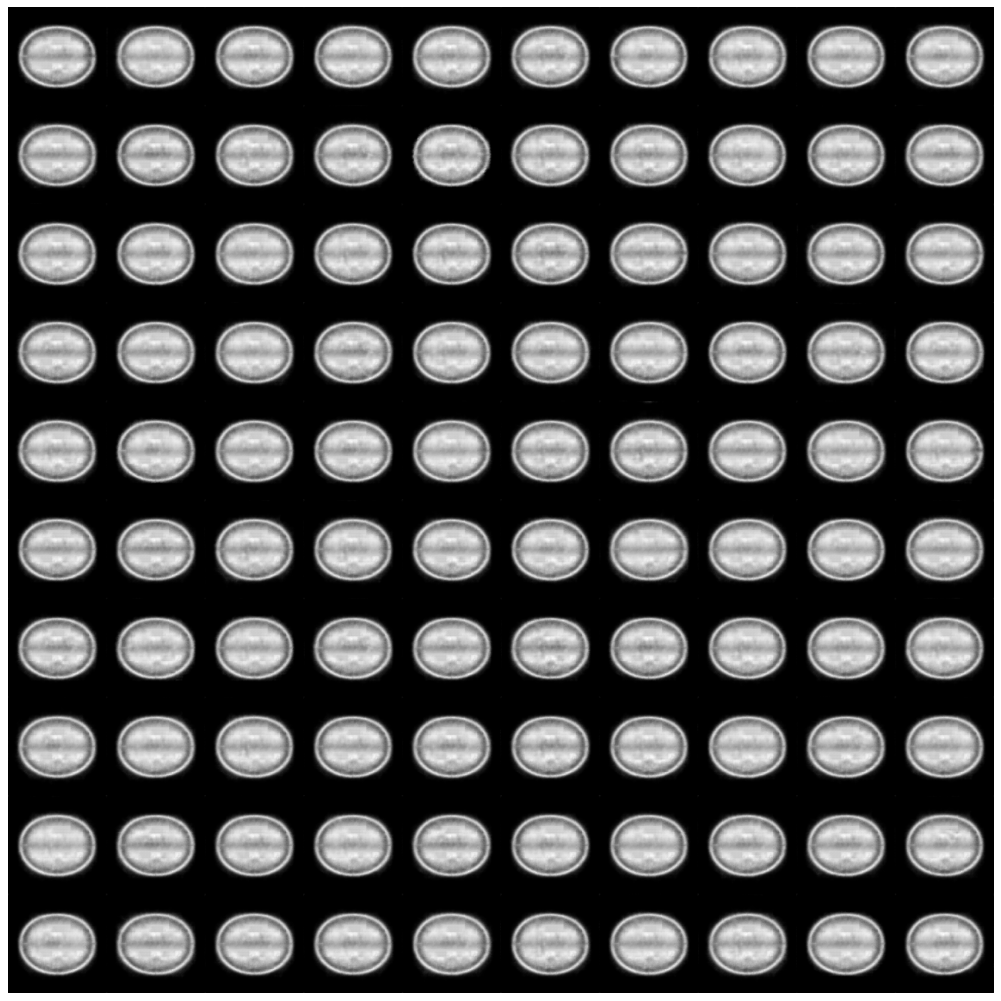

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Define grid dimensions
n = 10

# Create an empty placeholder for the images
image_grid = np.empty([128 * n, 128 * n])

model.eval()

# Loop through each grid point
for i in range(n):
    for j in range(n):
        z = torch.randn(batch_size, 64).to(device)

        # Decode the latent point
        with torch.no_grad():
            generated_image = model.decoder(z)

        generated_image = generated_image.cpu().numpy()  # Move the image to CPU and convert to NumPy array
        generated_image = np.squeeze(generated_image)  # Remove singleton dimensions

        image_grid[i * 128:(i + 1) * 128, j * 128:(j + 1) * 128] = generated_image[:1]  # Fill in the image grid

plt.figure(figsize=(16, 16), dpi=80)
plt.axis("off")
plt.imshow(image_grid, cmap='gray')
plt.show()
